The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.0-alpha1.post0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.1 MB/s 
     |████████████████████████████████| 120 kB 26.2 MB/s 
     |████████████████████████████████| 1.6 MB 54.2 MB/s 
     |████████████████████████████████| 82 kB 990 kB/s 


# Densely Connected Networks (DenseNet)
:label:`sec_densenet`

ResNet significantly changed the view of how to parametrize the functions in deep networks. *DenseNet* (dense convolutional network) is to some extent the logical extension of this :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`.
DenseNet is characterized by both the connectivity pattern where
each layer connects to all the preceding layers
and the concatenation operation (rather than the addition operator in ResNet) to preserve and reuse features
from earlier layers.
To understand how to arrive at it, let's take a small detour to mathematics.


## From ResNet to DenseNet

Recall the Taylor expansion for functions. For the point $x = 0$ it can be written as

$$f(x) = f(0) + x \cdot \left[f'(0) + x \cdot \left[\frac{f''(0)}{2!}  + x \cdot \left[\frac{f'''(0)}{3!}  + \ldots \right]\right]\right].$$


The key point is that it decomposes a function into increasingly higher order terms. In a similar vein, ResNet decomposes functions into

$$f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x}).$$

That is, ResNet decomposes $f$ into a simple linear term and a more complex
nonlinear one.
What if we wanted to capture (not necessarily add) information beyond two terms?
One such solution is DenseNet :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`.

![The main difference between ResNet (left) and DenseNet (right) in cross-layer connections: use of addition and use of concatenation. ](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/densenet-block.svg?raw=1)
:label:`fig_densenet_block`

As shown in :numref:`fig_densenet_block`, the key difference between ResNet and DenseNet is that in the latter case outputs are *concatenated* (denoted by $[,]$) rather than added.
As a result, we perform a mapping from $\mathbf{x}$ to its values after applying an increasingly complex sequence of functions:

$$\mathbf{x} \to \left[
\mathbf{x},
f_1(\mathbf{x}),
f_2\left(\left[\mathbf{x}, f_1\left(\mathbf{x}\right)\right]\right), f_3\left(\left[\mathbf{x}, f_1\left(\mathbf{x}\right), f_2\left(\left[\mathbf{x}, f_1\left(\mathbf{x}\right)\right]\right)\right]\right), \ldots\right].$$

In the end, all these functions are combined in MLP to reduce the number of features again. In terms of implementation this is quite simple:
rather than adding terms, we concatenate them. The name DenseNet arises from the fact that the dependency graph between variables becomes quite dense. The last layer of such a chain is densely connected to all previous layers. The dense connections are shown in :numref:`fig_densenet`.

![Dense connections in DenseNet. Note how the dimensionality increases with depth.](http://d2l.ai/_images/densenet.svg)
:label:`fig_densenet`

The main components that compose a DenseNet are *dense blocks* and *transition layers*. The former define how the inputs and outputs are concatenated, while the latter control the number of channels so that it is not too large, 
since the expansion $\mathbf{x} \to \left[\mathbf{x}, f_1(\mathbf{x}),
f_2\left(\left[\mathbf{x}, f_1\left(\mathbf{x}\right)\right]\right), \ldots \right]$ can be quite high-dimensional.


## [**Dense Blocks**]

DenseNet uses the modified "batch normalization, activation, and convolution"
structure of ResNet (see the exercise in :numref:`sec_resnet`).
First, we implement this convolution block structure.


In [2]:
import torch
from torch import nn
from d2l import torch as d2l


def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

A *dense block* consists of multiple convolution blocks, each using the same number of output channels. In the forward propagation, however, we concatenate the input and output of each convolution block on the channel dimension. Lazy evaluation allows us to adjust the dimensionality automatically.


In [3]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X

In the following example,
we [**define a `DenseBlock` instance**] with 2 convolution blocks of 10 output channels.
When using an input with 3 channels, we will get an output with  $3 + 10 + 10=23$ channels. The number of convolution block channels controls the growth in the number of output channels relative to the number of input channels. This is also referred to as the *growth rate*.


In [4]:
blk = DenseBlock(2, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 23, 8, 8])

## [**Transition Layers**]

Since each dense block will increase the number of channels, adding too many of them will lead to an excessively complex model. A *transition layer* is used to control the complexity of the model. It reduces the number of channels by using an $1\times 1$ convolution. Moreover, it halves the height and width via average pooling with a stride of 2.


In [5]:
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

[**Apply a transition layer**] with 10 channels to the output of the dense block in the previous example.  This reduces the number of output channels to 10, and halves the height and width.


In [6]:
blk = transition_block(10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

## [**DenseNet Model**]

Next, we will construct a DenseNet model. DenseNet first uses the same single convolutional layer and max-pooling layer as in ResNet.


In [7]:
class DenseNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

Then, similar to the four modules made up of residual blocks that ResNet uses,
DenseNet uses four dense blocks.
Similar to ResNet, we can set the number of convolutional layers used in each dense block. Here, we set it to 4, consistent with the ResNet-18 model in :numref:`sec_resnet`. Furthermore, we set the number of channels (i.e., growth rate) for the convolutional layers in the dense block to 32, so 128 channels will be added to each dense block.

In ResNet, the height and width are reduced between each module by a residual block with a stride of 2. Here, we use the transition layer to halve the height and width and halve the number of channels. Similar to ResNet, a global pooling layer and a fully connected layer are connected at the end to produce the output.


In [8]:
@d2l.add_to_class(DenseNet)
def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
             lr=0.1, num_classes=10):
    super(DenseNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, num_convs in enumerate(arch):
        self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                          growth_rate))
        # The number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        # A transition layer that halves the number of channels is added
        # between the dense blocks
        if i != len(arch) - 1:
            num_channels //= 2
            self.net.add_module(f'tran_blk{i+1}', transition_block(
                num_channels))
    self.net.add_module('last', nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

## [**Training**]

Since we are using a deeper network here, in this section, we will reduce the input height and width from 224 to 96 to simplify the computation.


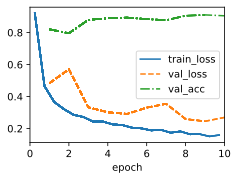

In [9]:
model = DenseNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

## Summary and Discussion

The main components that compose DenseNet are dense blocks and transition layers. For the latter, we need to keep the dimensionality under control when composing the network by adding transition layers that shrink the number of channels again.
In terms of cross-layer connections, unlike ResNet, where inputs and outputs are added together, DenseNet concatenates inputs and outputs on the channel dimension.
Although these concatenation operations
reuse features to achieve computational efficiency,
unfortunately they lead to heavy GPU memory consumption.
As a result,
applying DenseNet may require more memory-efficient implementations that may increase training time :cite:`pleiss2017memory`.


## Exercises

1. Why do we use average pooling rather than max-pooling in the transition layer?
1. One of the advantages mentioned in the DenseNet paper is that its model parameters are smaller than those of ResNet. Why is this the case?
1. One problem for which DenseNet has been criticized is its high memory consumption.
    1. Is this really the case? Try to change the input shape to $224\times 224$ to see the actual GPU memory consumption empirically.
    1. Can you think of an alternative means of reducing the memory consumption? How would you need to change the framework?
1. Implement the various DenseNet versions presented in Table 1 of the DenseNet paper :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`.
1. Design an MLP-based model by applying the DenseNet idea. Apply it to the housing price prediction task in :numref:`sec_kaggle_house`.


[Discussions](https://discuss.d2l.ai/t/88)
